 # ML for Environmental Engineering 
 By: Suheyla Tozan and Steven Gutterman

## Module Import

In [2]:
!pip install openpyxl
!pip install tensorflow
!pip install hyperopt
!pip install pandas
!pip install matplotlib
!pip install xarray
!pip install seaborn
!pip install scikit-learn
!pip install utils
!pip install keras
!pip install --upgrade tensorflow

In [3]:
!pip install xgboost==1.7.6


In [1]:
# Import Modules
import os
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb
print("xgboost version = ",xgb.__version__)

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import *

xgboost version =  2.0.2


## Data Processing

/var/folders/93/5t7_3xxn2dvdtnjj99wxz2wc0000gn/T/ipykernel_38549/1828264225.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:, 'wind speed'].fillna(df_new['wind speed'].mean(), inplace=True)
/var/folders/93/5t7_3xxn2dvdtnjj99wxz2wc0000gn/T/ipykernel_38549/1828264225.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:, 'wind direction'].fillna(df_new['wind direction'].mean(), inplace=True)
/var/folders/93/5t7_3xxn2dvdtnjj99wxz2wc0000gn/T/ipykernel_38549/1828264225.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

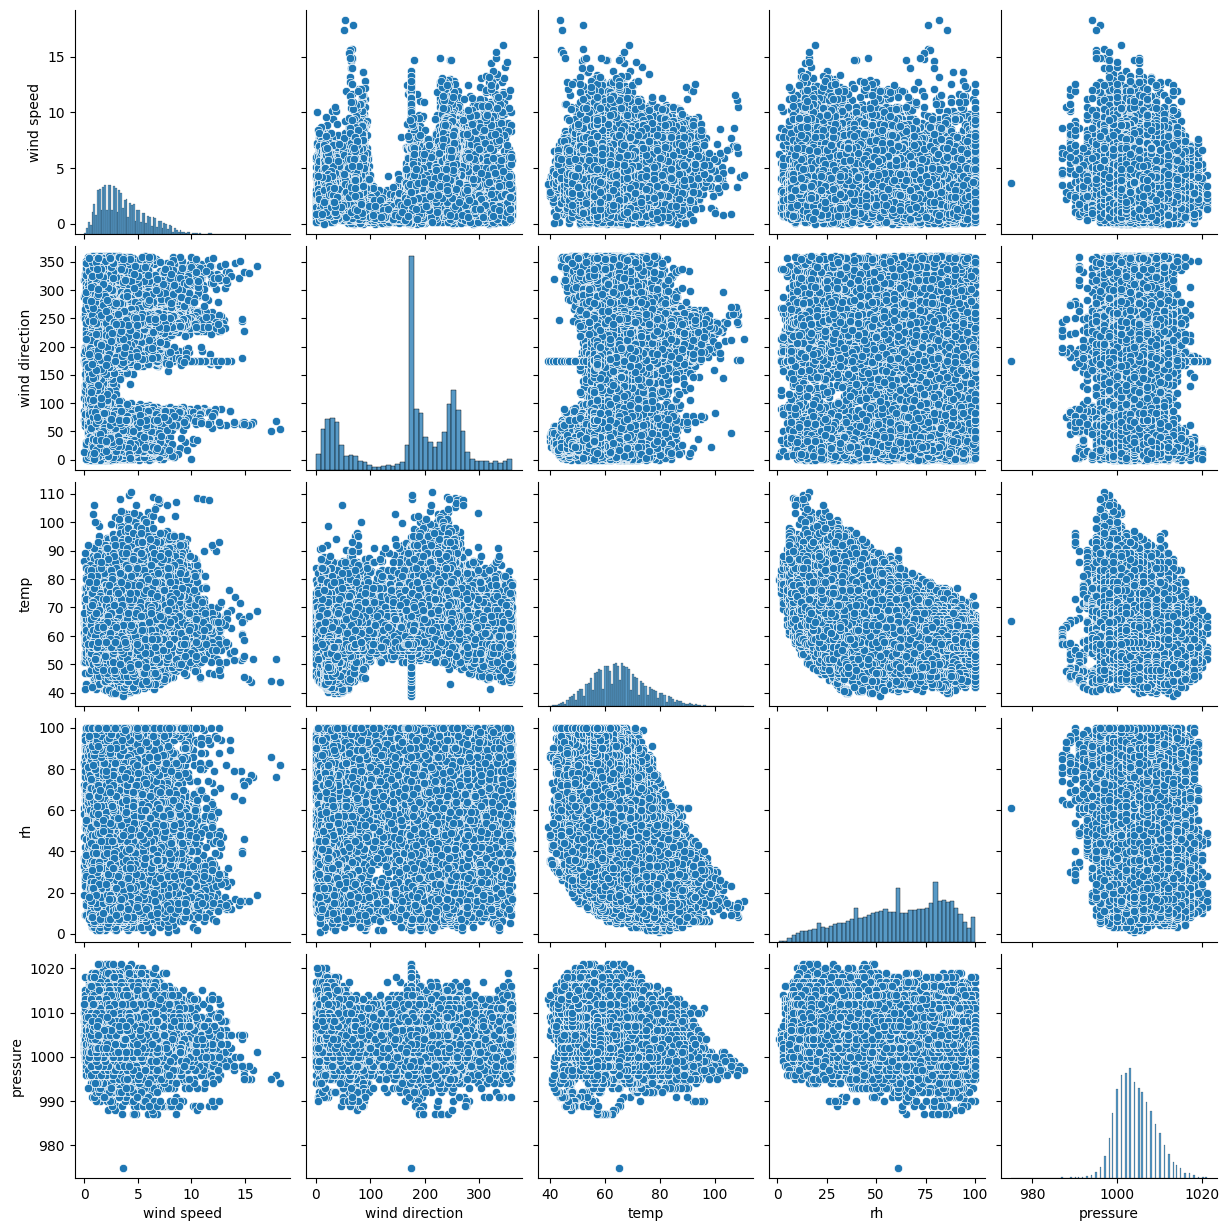

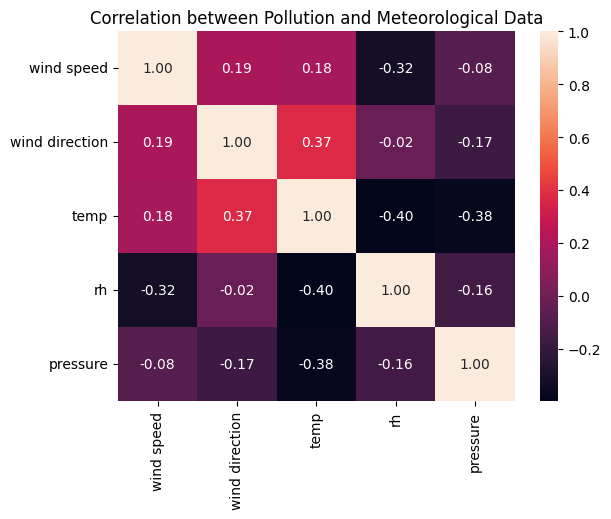

In [2]:
# 1. Data Processing: Prepare Data for Training & Testing

df = pd.read_excel("Data/metdata_2018-2023_ELABHWC.xlsx") #meterological data
df2 = pd.read_excel("Data/criteriagasdata_2018-2023_ELABHWC.xlsx") #air quality data


merged_df = pd.merge(df, df2, on=['date_gmt', 'time_gmt'], how='inner')
desired_columns = ['date_gmt', 'time_gmt', 'wind speed', 'wind direction', 'temp', 'rh', 'pressure', 'CO', 'NO2', 'SO2','O3','PM10']
final_df = merged_df[desired_columns]
co_original = final_df['CO']
no2_original = final_df['NO2']
so2_original = final_df['SO2']
o3_original = final_df['O3']
#Get rid of all predictand data that is 'NaN'
df_new = final_df.dropna(subset=['CO', 'NO2', 'SO2','O3'])

df_new.loc[:, 'wind speed'].fillna(df_new['wind speed'].mean(), inplace=True)
df_new.loc[:, 'wind direction'].fillna(df_new['wind direction'].mean(), inplace=True)
df_new.loc[:, 'temp'].fillna(df_new['temp'].mean(), inplace=True)
df_new.loc[:, 'rh'].fillna(df_new['rh'].mean(), inplace=True)
df_new.loc[:, 'pressure'].fillna(df_new['pressure'].mean(), inplace=True)

X_features = df_new[['wind speed', 'wind direction', 'temp', 'rh', 'pressure','date_gmt']]
y_co = df_new['CO']
y_no2 = df_new['NO2']
y_so2 = df_new['SO2']
y_o3 = df_new['O3']

#Pairplot
df_cor = df_new.drop(['date_gmt', 'time_gmt'], axis=1)
features = ['wind speed', 'wind direction', 'temp','rh','pressure']
subset_corr = df_cor[features]
sns.pairplot(subset_corr)
plt.savefig("pairplot.png")
plt.show()

#Heatmap
df_cor = df_new.drop(['date_gmt', 'time_gmt'], axis=1)
features = ['wind speed', 'wind direction', 'temp','rh','pressure']
subset_corr = df_cor[features]
correlation_matrix = subset_corr.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation between Pollution and Meteorological Data")
#plt.savefig("heatmap.png")
plt.show()


#Determine Train and Test Data

#CO
X_train_co,X_test_co,y_train_co,y_test_co = train_test_split(X_features, y_co, test_size = 0.30, random_state = 512)
X_train_co = X_train_co[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_co = X_test_co['date_gmt']
X_test_co = X_test_co [['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]

#NO2
X_train_no2,X_test_no2,y_train_no2,y_test_no2 = train_test_split(X_features, y_no2, test_size = 0.30, random_state = 512)
X_train_no2 = X_train_no2[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_no2 = X_test_no2['date_gmt']
X_test_no2 = X_test_no2 [['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]

#SO2
X_train_so2,X_test_so2,y_train_so2,y_test_so2 = train_test_split(X_features, y_so2, test_size = 0.30, random_state = 512)
X_train_so2 = X_train_so2[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_so2 = X_test_so2['date_gmt']
X_test_so2 = X_test_so2[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]

#O3
X_train_o3,X_test_o3,y_train_o3,y_test_o3 = train_test_split(X_features, y_o3, test_size = 0.30, random_state = 512)
X_train_o3 = X_train_o3[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_o3 = X_test_o3['date_gmt']
X_test_o3 = X_test_o3[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]


# Standardization
mean_co, std_co = X_train_co.mean(), X_train_co.std()
mean_no2, std_no2 = X_train_no2.mean(), X_train_no2.std()
mean_so2, std_so2 = X_train_so2.mean(), X_train_so2.std()
mean_o3, std_o3 = X_train_o3.mean(), X_train_o3.std()

#CO
X_train_co = (X_train_co - mean_co)/std_co
X_test_co = (X_test_co - mean_co)/std_co
#NO2
X_train_no2 = (X_train_no2 - mean_no2)/std_no2
X_test_no2 = (X_test_no2 - mean_no2)/std_no2
#SO2
X_train_so2 = (X_train_so2 - mean_so2)/std_so2
X_test_so2 = (X_test_so2 - mean_so2)/std_so2
#O3
X_train_o3 = (X_train_o3 - mean_o3)/std_o3
X_test_o3 = (X_test_o3 - mean_o3)/std_o3

X_train_fi_co = pd.DataFrame(X_train_co, columns=features)
X_train_co = X_train_co.to_numpy()
y_train_co = y_train_co.to_numpy()
X_test_co = X_test_co.to_numpy()

X_train_fi_no2 = pd.DataFrame(X_train_no2, columns=features)
X_train_no2 = X_train_no2.to_numpy()
y_train_no2 = y_train_no2.to_numpy()
X_test_no2 = X_test_no2.to_numpy()

X_train_fi_so2 = pd.DataFrame(X_train_so2, columns=features)
X_train_so2 = X_train_so2.to_numpy()
y_train_so2 = y_train_so2.to_numpy()
X_test_so2 = X_test_so2.to_numpy()

X_train_fi_o3 = pd.DataFrame(X_train_o3, columns=features)
X_train_o3 = X_train_o3.to_numpy()
y_train_o3 = y_train_o3.to_numpy()
X_test_o3 = X_test_o3.to_numpy()

## Function for Model Evaluation

In [3]:
#Feature Importance
# The code below was retained from the following website with slight modifications: 
#https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html

def plot_feature_importance(importance,names, model, gas):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(6,6))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model}: {gas} Concentration Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

#Prediction Error Histogram
def prediction_error(outcome, input, model, gas):
    errors = outcome - input
    plt.hist(errors, bins=30, edgecolor='black', alpha=0.5)
    plt.title(f'{model}: {gas} Concentration Model Evlaution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')

## CO Model Building

In [6]:
X_length = np.array([len(X_train_co)])

start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 1
X_train_all_co = []
y_train_all_co = []

for i in range(len(X_length)):
    
    X_subset = X_train_co[start[i]:end[i],:]
    y_subset = y_train_co[start[i]:end[i]]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, X_length[i]-slider+1)])
    
    X_train_all_co.append(X_subset)
    y_train_all_co.append(y_subset)
    
X_train_co = np.concatenate(X_train_all_co,axis=0)
y_train_co = np.concatenate(y_train_all_co,axis=0)
X_test_co  = np.array([X_test_co[i:i+slider] for i in range(0, X_test_co.shape[0]-slider+1)])
print(X_train_co.shape,y_train_co.shape,X_test_co.shape)

(28457, 1, 5) (28457, 1) (12196, 1, 5)


In [7]:
#Set Hyperparameters
n_neuron       = 32
activation     = 'relu'
num_epochs     = 30
learning_rate  = 0.001
minibatch_size = 32
model_num      = 1

#X_train__coreshaped = X_train_co.reshape((X_train_co.shape[0], 1, X_train_co.shape[1]))

lstm_model1 = Sequential()
lstm_model1.add(LSTM(n_neuron,input_shape=(X_train_co.shape[1],X_train_co.shape[2]),
               return_sequences=True,activation=activation))
lstm_model1.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model1.add(Dense(n_neuron,activation=activation))
lstm_model1.add(Dense(1,activation='linear')) 

lstm_model1.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model1.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history1 = lstm_model1.fit(X_train_co, y_train_co, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)
cwd = os.getcwd()
model_path = os.path.join(cwd,'saved_model')
lstm_model1.save(os.path.join(model_path,'LSTM_CO.h5'))
lstm_model1 = load_model(os.path.join(model_path,'LSTM_CO.h5'))

#X_test_co_reshaped = X_test_co.reshape((X_test_co.shape[0], 1, X_test_co.shape[1]))
y_test_pre_co3 = lstm_model1.predict(X_test_co)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 32)             4864      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14273 (55.75 KB)
Trainable params: 14273 (55.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
712/712 [==============================] - 2s 1ms/step - loss: 0.0570 - val_loss: 0.0450
Epoch 2/30
712/712 [==============================

/Users/steven.gutterman/ENTER/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


382/382 [==============================] - 0s 390us/step


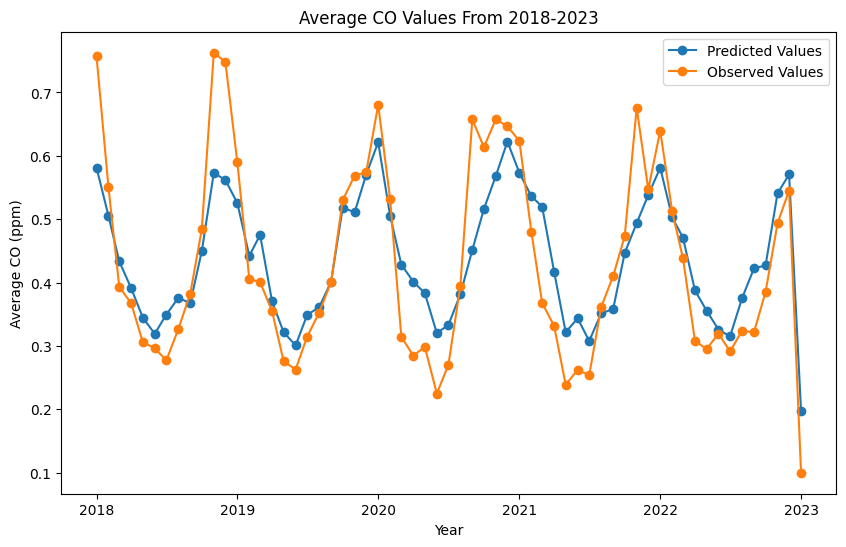

Mean Squared Error: 0.04026002893480204
Mean Absolute Error: 0.138072164181257
Root Mean Squared Error: 0.20064901927196663
0.7365615684721913


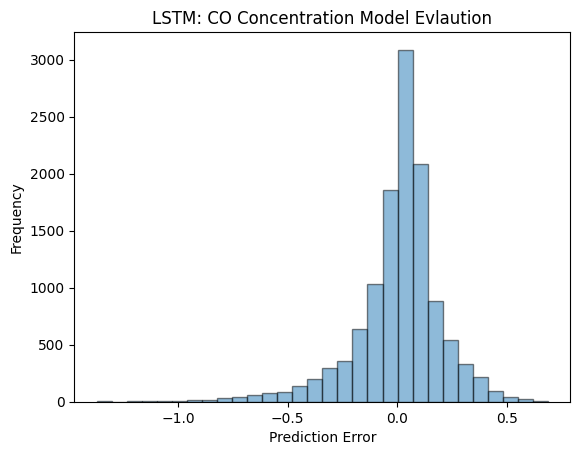

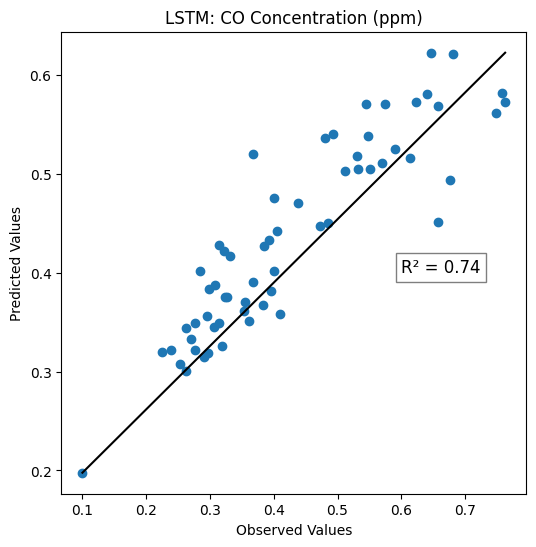

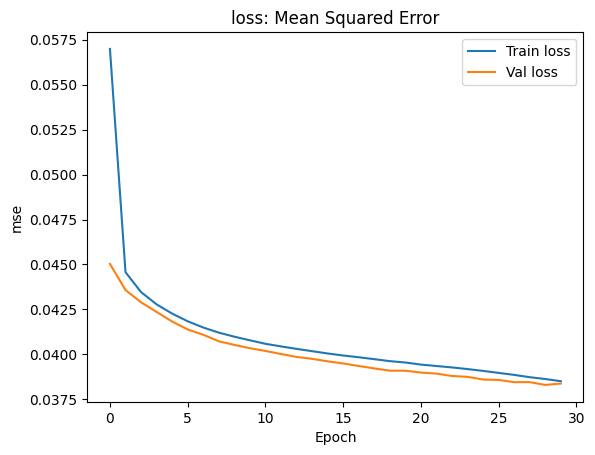

In [8]:
# CO

#X_test_co_reshaped = X_test_co.reshape((X_test_co.shape[0], 1, X_test_co.shape[1]))
#y_test_pre_co3 = lstm_model1.predict(X_test_co_reshaped)
# Organize data into monthly averages and plot
y_test_pre_co3 = y_test_pre_co3.flatten()
y_test_pre_co3 = pd.Series(y_test_pre_co3)
y_test_pre_co3 = y_test_pre_co3.reset_index(drop=True)
time_test_co = time_test_co.reset_index(drop=True)
co_df  = pd.concat([y_test_pre_co3, time_test_co], axis=1)
co_df.columns = ['CO', 'Date']
co_df['Date'] = pd.to_datetime(co_df['Date'])

# Extract year and month into new columns
co_df['Year'] = co_df['Date'].dt.year
co_df['Month'] = co_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
average_values = co_df.groupby(['Year', 'Month'])['CO'].mean()
average_values_df1 = average_values.reset_index()

#Repeat all above for observed data
y_test_co = pd.Series(y_test_co)
y_test_co = y_test_co.reset_index(drop=True)
co_test_df = pd.concat([y_test_co, time_test_co], axis=1)
co_test_df.columns = ['CO', 'Date']
co_test_df['Date'] = pd.to_datetime(co_test_df['Date'])

# Extract year and month into new columns
co_test_df['Year'] = co_test_df['Date'].dt.year
co_test_df['Month'] = co_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
average_values1 = co_test_df.groupby(['Year', 'Month'])['CO'].mean()
average_values_df2 = average_values1.reset_index()

#Change the series values to dataframes.
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(average_values_df1['Date'], average_values_df1['CO'], marker='o', label="Predicted Values")  
plt.plot(average_values_df2['Date'], average_values_df2['CO'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average CO Values From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average CO (ppm)')
plt.legend()
plt.show()

# evaluate the predictions
mse_co = mean_squared_error(y_test_co, y_test_pre_co3)
print("Mean Squared Error:", mse_co)

mae_co = mean_absolute_error(y_test_co, y_test_pre_co3)
print(f"Mean Absolute Error: {mae_co}")

rmse_co = mean_squared_error(y_test_co, y_test_pre_co3, squared=False)
print(f"Root Mean Squared Error: {rmse_co}")

#Error Prediction Histogram
prediction_error(y_test_pre_co3, y_test_co,'LSTM', 'CO')

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(average_values_df2['CO'], average_values_df1['CO'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(average_values_df2['CO'], average_values_df1['CO'])
plt.plot([average_values_df2['CO'].min(), average_values_df2['CO'].max()], [average_values_df1['CO'].min(), average_values_df1['CO'].max()], 'k-')  
plt.title(f'LSTM: CO Concentration (ppm)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(0.6, 0.4 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

plt.plot()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('loss: Mean Squared Error')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'])
#plt.savefig("LSTMCO.png")



## NO2 Model Building

In [9]:
X_length_no2 = np.array([len(X_train_no2)])

start = np.cumsum(X_length_no2) - X_length_no2
end   = np.cumsum(X_length_no2)

slider = 1
X_train_all_no2 = []
y_train_all_no2 = []

for i in range(len(X_length_no2)):
    
    X_subset_no2 = X_train_no2[start[i]:end[i],:]
    y_subset_no2 = y_train_no2[start[i]:end[i]]
    
    X_subset_no2 = np.array([X_subset_no2[i:i+slider] for i in range(0, X_length_no2[i]-slider+1)])
    y_subset_no2 = np.array([[y_subset_no2[i+slider-1]] for i in range(0, X_length_no2[i]-slider+1)])
    
    X_train_all_no2.append(X_subset_no2)
    y_train_all_no2.append(y_subset_no2)
    
X_train_no2 = np.concatenate(X_train_all_no2,axis=0)
y_train_no2 = np.concatenate(y_train_all_no2,axis=0)
X_test_no2  = np.array([X_test_no2[i:i+slider] for i in range(0, X_test_no2.shape[0]-slider+1)])
print(X_train_no2.shape,y_train_no2.shape,X_test_no2.shape)

(28457, 1, 5) (28457, 1) (12196, 1, 5)


In [10]:
#Set Hyperparameters
n_neuron       = 32
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 32
model_num      = 1

#X_train__coreshaped = X_train_co.reshape((X_train_co.shape[0], 1, X_train_co.shape[1]))

lstm_model2 = Sequential()
lstm_model2.add(LSTM(n_neuron,input_shape=(X_train_no2.shape[1],X_train_no2.shape[2]),
               return_sequences=True,activation=activation))
lstm_model2.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model2.add(Dense(n_neuron,activation=activation))
lstm_model2.add(Dense(1,activation='linear')) 

lstm_model2.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model2.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history2 = lstm_model2.fit(X_train_no2, y_train_no2, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)
cwd = os.getcwd()
model_path = os.path.join(cwd,'saved_model')
lstm_model2.save(os.path.join(model_path,'LSTM_NO2.h5'))
lstm_model2 = load_model(os.path.join(model_path,'LSTM_NO2.h5'))

#X_test_co_reshaped = X_test_co.reshape((X_test_co.shape[0], 1, X_test_co.shape[1]))
y_test_pre_no23 = lstm_model2.predict(X_test_no2)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 32)             4864      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14273 (55.75 KB)
Trainable params: 14273 (55.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
712/712 [==============================] - 2s 1ms/step - loss: 144.7952 - val_loss: 83.5052
Epoch 2/50
712/712 [===========================

/Users/steven.gutterman/ENTER/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


382/382 [==============================] - 0s 406us/step


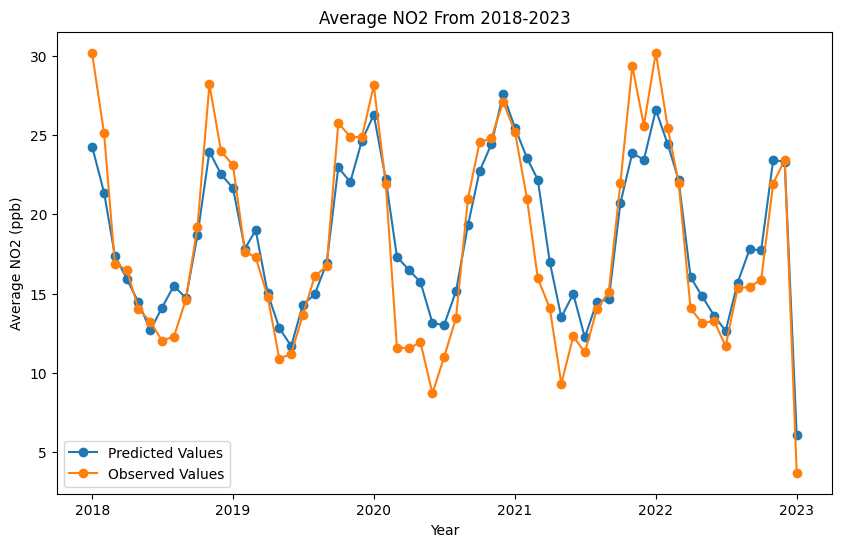

Mean Squared Error: 64.66343308757934
Mean Absolute Error: 5.8571435019417875
Root Mean Squared Error: 8.04135766444817
0.8434822714286527


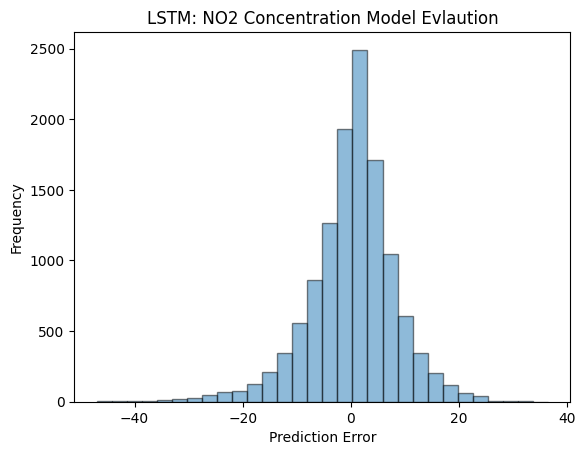

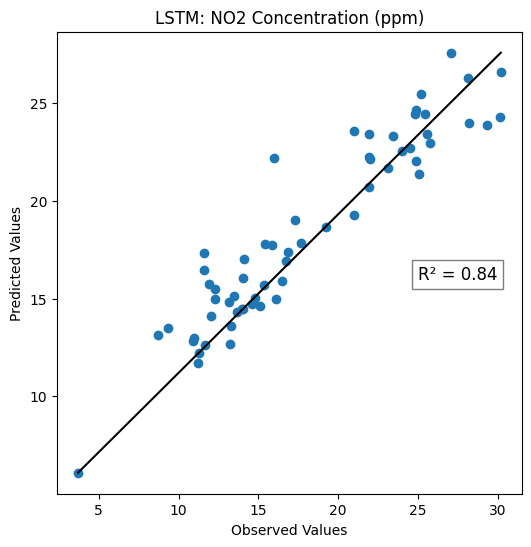

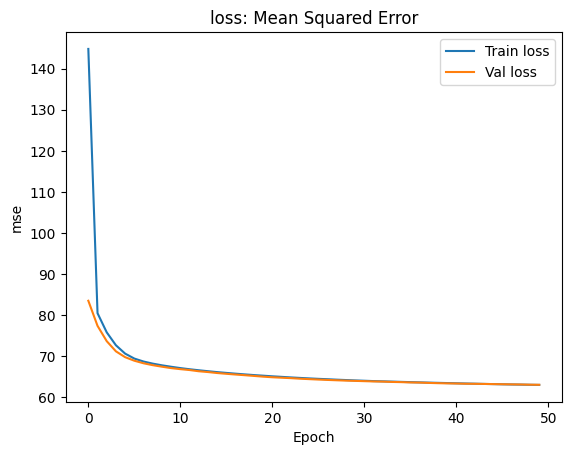

In [11]:
# Organize data into monthly averages and plot
y_test_pre_no23 = y_test_pre_no23.flatten()
y_test_pre_no23 = pd.Series(y_test_pre_no23)
y_test_pre_no23 = y_test_pre_no23.reset_index(drop=True)
time_test_no2 = time_test_no2.reset_index(drop=True)
no2_df  = pd.concat([y_test_pre_no23, time_test_no2], axis=1)
no2_df.columns = ['NO2', 'Date']
no2_df['Date'] = pd.to_datetime(no2_df['Date'])

# Extract year and month into new columns
no2_df['Year'] = no2_df['Date'].dt.year
no2_df['Month'] = no2_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
no2_average_values = no2_df.groupby(['Year', 'Month'])['NO2'].mean()
no2_average_values_df1 = no2_average_values.reset_index()

#Repeat all above for observed data
y_test_no2 = pd.Series(y_test_no2)
y_test_no2 = y_test_no2.reset_index(drop=True)
time_test_no2 = time_test_no2.reset_index(drop=True)
no2_test_df = pd.concat([y_test_no2, time_test_no2], axis=1)
no2_test_df.columns = ['NO2', 'Date']
no2_test_df['Date'] = pd.to_datetime(no2_test_df['Date'])

# Extract year and month into new columns
no2_test_df['Year'] = no2_test_df['Date'].dt.year
no2_test_df['Month'] = no2_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
no2_average_values1 = no2_test_df.groupby(['Year', 'Month'])['NO2'].mean()
no2_average_values_df2 = no2_average_values1.reset_index()

#Change the series values to dataframes.
no2_average_values_df1['Date'] = pd.to_datetime(no2_average_values_df1['Year'].astype(str) + '-' + no2_average_values_df1['Month'].astype(str))
no2_average_values_df2['Date'] = pd.to_datetime(no2_average_values_df2['Year'].astype(str) + '-' + no2_average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(no2_average_values_df1['Date'], no2_average_values_df1['NO2'], marker='o', label="Predicted Values")  # Create a line plot
plt.plot(no2_average_values_df2['Date'], no2_average_values_df2['NO2'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average NO2 From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average NO2 (ppb)')
plt.legend()
plt.show()

# evaluate the predictions
mse_no2 = mean_squared_error(y_test_no2, y_test_pre_no23)
print("Mean Squared Error:", mse_no2)

mae_no2 = mean_absolute_error(y_test_no2, y_test_pre_no23)
print(f"Mean Absolute Error: {mae_no2}")

rmse_no2 = mean_squared_error(y_test_no2, y_test_pre_no23, squared=False)
print(f"Root Mean Squared Error: {rmse_no2}")

#Error Prediction Histogram
prediction_error(y_test_pre_no23, y_test_no2,'LSTM', 'NO2')

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(no2_average_values_df2['NO2'], no2_average_values_df1['NO2'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(no2_average_values_df2['NO2'], no2_average_values_df1['NO2'])
plt.plot([no2_average_values_df2['NO2'].min(), no2_average_values_df2['NO2'].max()], [no2_average_values_df1['NO2'].min(), no2_average_values_df1['NO2'].max()], 'k-')  
plt.title(f'LSTM: NO2 Concentration (ppm)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(25, 16 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

plt.plot()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('loss: Mean Squared Error')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'])
#plt.savefig("LSTMNO2.png")

## SO2 Model Building

In [12]:
X_length_so2 = np.array([len(X_train_so2)])

start = np.cumsum(X_length_so2) - X_length_so2
end   = np.cumsum(X_length_so2)

slider = 1
X_train_all_so2 = []
y_train_all_so2 = []

for i in range(len(X_length_so2)):
    
    X_subset_so2 = X_train_so2[start[i]:end[i],:]
    y_subset_so2 = y_train_so2[start[i]:end[i]]
    
    X_subset_so2 = np.array([X_subset_so2[i:i+slider] for i in range(0, X_length_so2[i]-slider+1)])
    y_subset_so2 = np.array([[y_subset_so2[i+slider-1]] for i in range(0, X_length_so2[i]-slider+1)])
    
    X_train_all_so2.append(X_subset_so2)
    y_train_all_so2.append(y_subset_so2)
    
X_train_so2 = np.concatenate(X_train_all_so2,axis=0)
y_train_so2 = np.concatenate(y_train_all_so2,axis=0)
X_test_so2  = np.array([X_test_so2[i:i+slider] for i in range(0, X_test_so2.shape[0]-slider+1)])
print(X_train_so2.shape,y_train_so2.shape,X_test_so2.shape)

(28457, 1, 5) (28457, 1) (12196, 1, 5)


In [13]:
# The following code was used from 
# https://datasciencetoday.net/index.php/en-us/machine-learning/210-how-do-hyperparameter-optimization-libraries-in-python-work

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

activation = 'linear'
learning_rate = 0.001

def lstm_model_builder(hyperparameters):
    # Create the LSTM model using hyperparameters
    lstm_model3 = Sequential()
    n_units = hyperparameters[0]
    lstm_model3.add(LSTM(n_units,input_shape=(X_train_so2.shape[1],X_train_so2.shape[2]),return_sequences=True,activation=activation))
    lstm_model3.add(LSTM(n_units,return_sequences=True,activation=activation))
    lstm_model3.add(LSTM(n_units,return_sequences=False,activation=activation))
    lstm_model3.add(Dense(n_units,activation=activation))
    lstm_model3.add(Dense(1,activation='relu')) 
    lstm_model3.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    lstm_model3.summary()

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    batch_size = hyperparameters[2] 
    epochs = hyperparameters[1] 

    history4 = lstm_model4.fit(X_train_so2, y_train_so2, 
                           batch_size=batch_size,  # Corrected keyword
                           epochs=epochs,  # Corrected keyword
                           validation_split=0.2, verbose=1,
                           callbacks=[early_stop],
                           shuffle=False)

    # Evaluate the model
    y_test_pre_so2 = lstm_model4.predict(X_test_so2)
    mse1 = mean_squared_error(y_test_so2, y_test_pre_so2)

    return mse1  # Or return -me if you want the optimizer to maximize MSE


In [14]:
from skopt import gp_minimize
from skopt.space import Real, Integer

# Define the space of hyperparameters to search
search_space = [Integer(64, 300, name='n_units'),
                Integer(10, 100, name='epochs'),
                Integer(32, 128, name='batch_size'),]

# Run Bayesian optimization
results = gp_minimize(lstm_model_builder, search_space, n_calls=10, random_state=0)

best_hyperparams = results.x
print("Best hyperparameters: ", best_hyperparams)



AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [15]:
#Set Hyperparameters
# n_neuron       = 204
# activation     = 'relu' #linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
# num_epochs     = 86
# learning_rate  = 0.001
# minibatch_size = 114
# model_num      = 1

n_neuron       = 204
activation     = 'linear' #linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 86
learning_rate  = 0.001
minibatch_size = 114
model_num      = 1

#X_train__coreshaped = X_train_co.reshape((X_train_co.shape[0], 1, X_train_co.shape[1]))

lstm_model3 = Sequential()
lstm_model3.add(LSTM(n_neuron,input_shape=(X_train_so2.shape[1],X_train_so2.shape[2]),
               return_sequences=True,activation=activation))
lstm_model3.add(LSTM(n_neuron,return_sequences=True,
               activation=activation))
lstm_model3.add(LSTM(n_neuron,return_sequences=True,
               activation=activation))
lstm_model3.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model3.add(Dense(n_neuron,activation=activation))
lstm_model3.add(Dense(1,activation='linear')) 

lstm_model3.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model3.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history3 = lstm_model3.fit(X_train_so2, y_train_so2, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)
cwd = os.getcwd()
model_path = os.path.join(cwd,'saved_model')
lstm_model3.save(os.path.join(model_path,'LSTM_SO2.h5'))
lstm_model3 = load_model(os.path.join(model_path,'LSTM_SO2.h5'))

#X_test_co_reshaped = X_test_co.reshape((X_test_co.shape[0], 1, X_test_co.shape[1]))
y_test_pre_so23 = lstm_model3.predict(X_test_so2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 204)            171360    
                                                                 
 lstm_5 (LSTM)               (None, 1, 204)            333744    
                                                                 
 lstm_6 (LSTM)               (None, 1, 204)            333744    
                                                                 
 lstm_7 (LSTM)               (None, 204)               333744    
                                                                 
 dense_4 (Dense)             (None, 204)               41820     
                                                                 
 dense_5 (Dense)             (None, 1)                 205       
                                                                 
Total params: 1214617 (4.63 MB)
Trainable params: 1214

/Users/steven.gutterman/ENTER/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


382/382 [==============================] - 1s 2ms/step


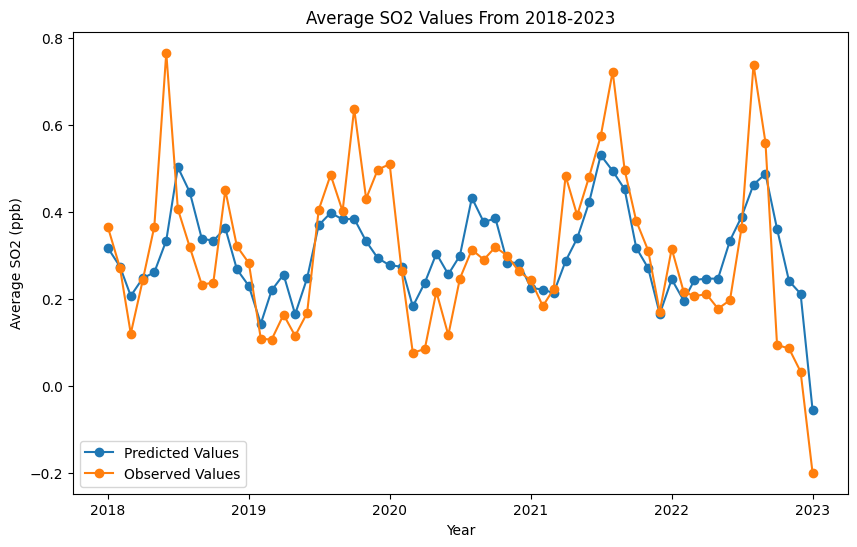

Mean Squared Error: 0.062084899838409646
Mean Absolute Error: 0.17105016721606198
Root Mean Squared Error: 0.24916841661496678
0.5310613734996996


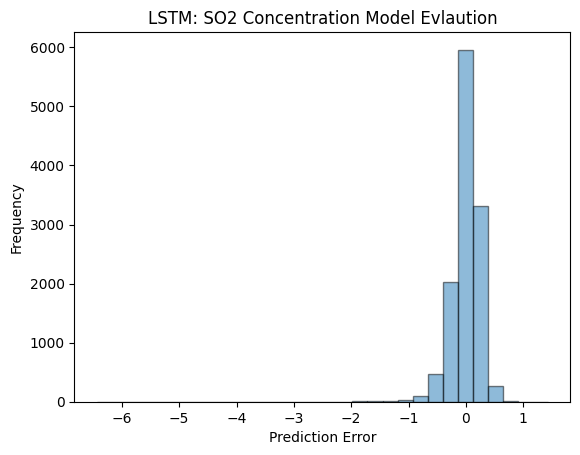

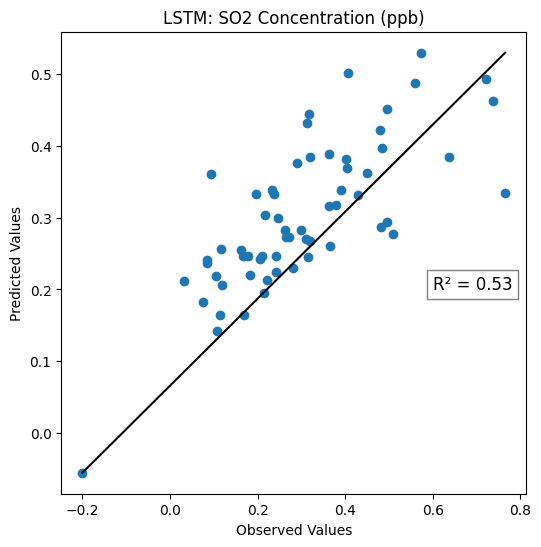

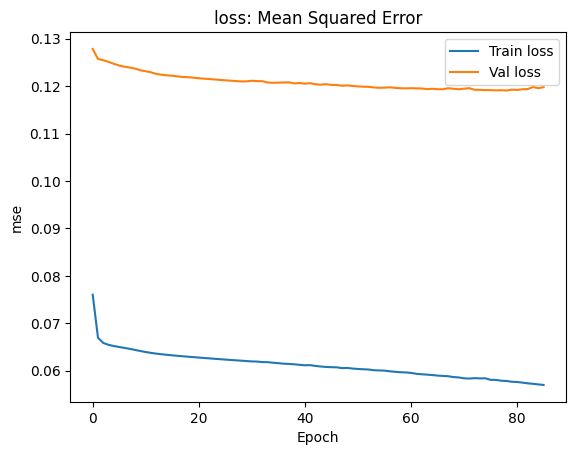

In [16]:
## Organize data into monthly averages and plot
y_test_pre_so23 = y_test_pre_so23.flatten()
y_test_pre_so23 = pd.Series(y_test_pre_so23)
y_test_pre_so23 = y_test_pre_so23.reset_index(drop=True)
time_test_so2 = time_test_so2.reset_index(drop=True)
so2_df  = pd.concat([y_test_pre_so23, time_test_so2], axis=1)
so2_df.columns = ['SO2', 'Date']
so2_df['Date'] = pd.to_datetime(so2_df['Date'])

# Extract year and month into new columns
so2_df['Year'] = so2_df['Date'].dt.year
so2_df['Month'] = so2_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
so2_average_values = so2_df.groupby(['Year', 'Month'])['SO2'].mean()
so2_average_values_df1 = so2_average_values.reset_index()

#Repeat all above for observed data
y_test_so2 = pd.Series(y_test_so2)
y_test_so2 = y_test_so2.reset_index(drop=True)
time_test_so2 = time_test_so2.reset_index(drop=True)
so2_test_df = pd.concat([y_test_so2, time_test_so2], axis=1)
so2_test_df.columns = ['SO2', 'Date']
so2_test_df['Date'] = pd.to_datetime(so2_test_df['Date'])

# Extract year and month into new columns
so2_test_df['Year'] = so2_test_df['Date'].dt.year
so2_test_df['Month'] = so2_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
so2_average_values1 = so2_test_df.groupby(['Year', 'Month'])['SO2'].mean()
so2_average_values_df2 = so2_average_values1.reset_index()

#Change the series values to dataframes.
so2_average_values_df1['Date'] = pd.to_datetime(so2_average_values_df1['Year'].astype(str) + '-' + so2_average_values_df1['Month'].astype(str))
so2_average_values_df2['Date'] = pd.to_datetime(so2_average_values_df2['Year'].astype(str) + '-' + so2_average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(so2_average_values_df1['Date'], so2_average_values_df1['SO2'], marker='o', label="Predicted Values")  # Create a line plot
plt.plot(so2_average_values_df2['Date'], so2_average_values_df2['SO2'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average SO2 Values From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average SO2 (ppb)')
plt.legend()
plt.show()

# evaluate the predictions
mse_so2 = mean_squared_error(y_test_so2, y_test_pre_so23)
print("Mean Squared Error:", mse_so2)

mae_so2 = mean_absolute_error(y_test_so2, y_test_pre_so23)
print(f"Mean Absolute Error: {mae_so2}")

rmse_so2 = mean_squared_error(y_test_so2, y_test_pre_so23, squared=False)
print(f"Root Mean Squared Error: {rmse_so2}")

#Prediction Error Histogram
prediction_error(y_test_pre_so23, y_test_so2, 'LSTM','SO2')

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(so2_average_values_df2['SO2'], so2_average_values_df1['SO2'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(so2_average_values_df2['SO2'], so2_average_values_df1['SO2'])
plt.plot([so2_average_values_df2['SO2'].min(), so2_average_values_df2['SO2'].max()], [so2_average_values_df1['SO2'].min(), so2_average_values_df1['SO2'].max()], 'k-')  
plt.title(f'LSTM: SO2 Concentration (ppb)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(0.6, 0.2 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

plt.plot()
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('loss: Mean Squared Error')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'])
plt.savefig("LSTMSO2.png")


## O3 Model Building

In [17]:
X_length_o3 = np.array([len(X_train_o3)])

start = np.cumsum(X_length_o3) - X_length_o3
end   = np.cumsum(X_length_o3)

slider = 1
X_train_all_o3 = []
y_train_all_o3 = []

for i in range(len(X_length_o3)):
    
    X_subset_o3 = X_train_o3[start[i]:end[i],:]
    y_subset_o3 = y_train_o3[start[i]:end[i]]
    
    X_subset_o3 = np.array([X_subset_o3[i:i+slider] for i in range(0, X_length_o3[i]-slider+1)])
    y_subset_o3 = np.array([[y_subset_o3[i+slider-1]] for i in range(0, X_length_o3[i]-slider+1)])
    
    X_train_all_o3.append(X_subset_o3)
    y_train_all_o3.append(y_subset_o3)
    
X_train_o3 = np.concatenate(X_train_all_o3,axis=0)
y_train_o3 = np.concatenate(y_train_all_o3,axis=0)
X_test_o3  = np.array([X_test_o3[i:i+slider] for i in range(0, X_test_o3.shape[0]-slider+1)])
print(X_train_o3.shape,y_train_o3.shape,X_test_o3.shape)

(28457, 1, 5) (28457, 1) (12196, 1, 5)


In [18]:
# The following code was used from 
# https://datasciencetoday.net/index.php/en-us/machine-learning/210-how-do-hyperparameter-optimization-libraries-in-python-work
# This code was used to find an inital point for hyperparameter tuning. Afterwards, manual tunning was applied based on the inital results from 
# gp_minimize
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

activation = 'linear'
learning_rate = 0.001

def lstm_model_builder(hyperparameters):
    # Create the LSTM model using hyperparameters
    lstm_model4 = Sequential()
    n_units = hyperparameters[0]
    lstm_model4.add(LSTM(n_units,input_shape=(X_train_o3.shape[1],X_train_o3.shape[2]),return_sequences=True,activation=activation))
    lstm_model4.add(LSTM(n_units,return_sequences=True,activation=activation))
    lstm_model4.add(LSTM(n_units,return_sequences=False,activation=activation))
    lstm_model4.add(Dense(n_units,activation=activation))
    lstm_model4.add(Dense(1,activation='relu')) 
    lstm_model4.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    lstm_model4.summary()

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    batch_size = hyperparameters[2] 
    epochs = hyperparameters[1] 

    history4 = lstm_model4.fit(X_train_o3, y_train_o3, 
                           batch_size=batch_size,  # Corrected keyword
                           epochs=epochs,  # Corrected keyword
                           validation_split=0.2, verbose=1,
                           callbacks=[early_stop],
                           shuffle=False)

    # Evaluate the model
    y_test_pre_o33 = lstm_model4.predict(X_test_o3)
    mse = mean_squared_error(y_test_o3, y_test_pre_o33)

    return mse  # Or return -me if you want the optimizer to maximize MSE


In [19]:
from skopt import gp_minimize
from skopt.space import Real, Integer

# Define the space of hyperparameters to search
search_space = [Integer(64, 200, name='n_units'),
                Integer(10, 100, name='epochs'),
                Integer(32, 128, name='batch_size'),]

# Run Bayesian optimization
results = gp_minimize(lstm_model_builder, search_space, n_calls=10, random_state=0)

best_hyperparams = results.x
print("Best hyperparameters: ", best_hyperparams)



AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [20]:
#Set Hyperparameters
n_neuron       = 400
activation     = 'linear' #linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 85
learning_rate  = 0.001
minibatch_size = 64

#X_train__coreshaped = X_train_co.reshape((X_train_co.shape[0], 1, X_train_co.shape[1]))

lstm_model4 = Sequential()
lstm_model4.add(LSTM(n_neuron,input_shape=(X_train_o3.shape[1],X_train_o3.shape[2]),
               return_sequences=True,activation=activation))
lstm_model4.add(LSTM(n_neuron,return_sequences=True,
               activation=activation))
lstm_model4.add(LSTM(n_neuron,return_sequences=True,
               activation=activation))
lstm_model4.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model4.add(Dense(n_neuron,activation=activation))
lstm_model4.add(Dense(1,activation='linear')) 

lstm_model4.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model4.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history4 = lstm_model4.fit(X_train_o3, y_train_o3, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)
cwd = os.getcwd()
model_path = os.path.join(cwd,'saved_model')
lstm_model4.save(os.path.join(model_path,'LSTM_O3.h5'))
lstm_model4 = load_model(os.path.join(model_path,'LSTM_O3.h5'))

#X_test_co_reshaped = X_test_co.reshape((X_test_co.shape[0], 1, X_test_co.shape[1]))
y_test_pre_o33 = lstm_model4.predict(X_test_o3)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 400)            649600    
                                                                 
 lstm_9 (LSTM)               (None, 1, 400)            1281600   
                                                                 
 lstm_10 (LSTM)              (None, 1, 400)            1281600   
                                                                 
 lstm_11 (LSTM)              (None, 400)               1281600   
                                                                 
 dense_6 (Dense)             (None, 400)               160400    
                                                                 
 dense_7 (Dense)             (None, 1)                 401       
                                                                 
Total params: 4655201 (17.76 MB)
Trainable params: 465

/Users/steven.gutterman/ENTER/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


382/382 [==============================] - 2s 4ms/step


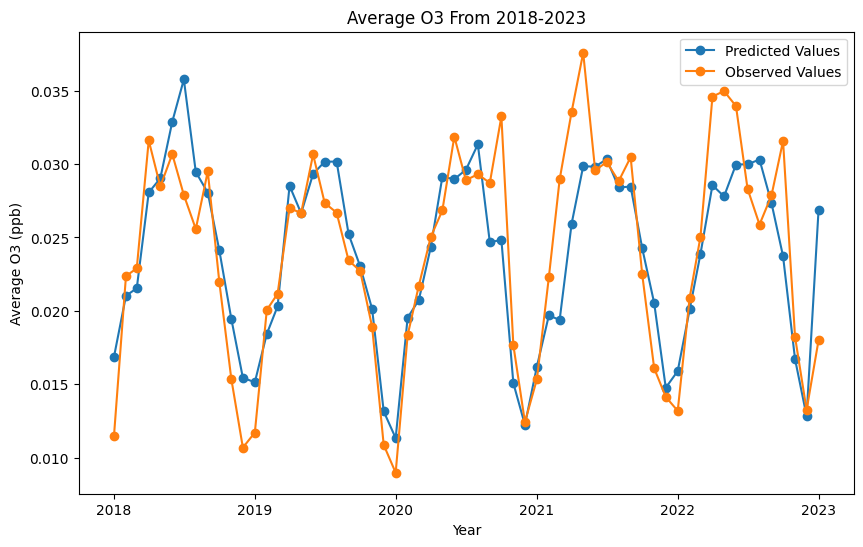

Mean Squared Error: 9.935369235734418e-05
Mean Absolute Error: 0.007535847242085874
Root Mean Squared Error: 0.00996763223425424
0.7224230873640052


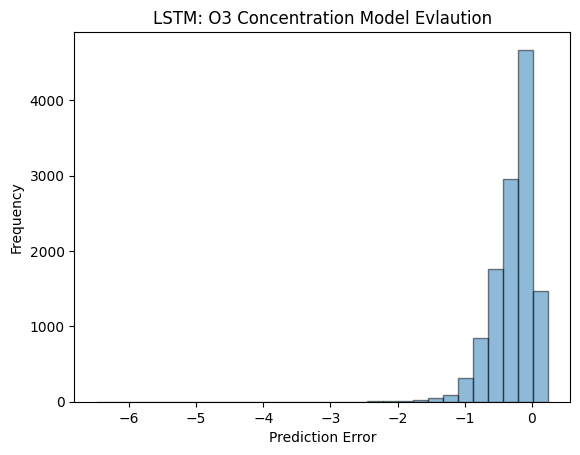

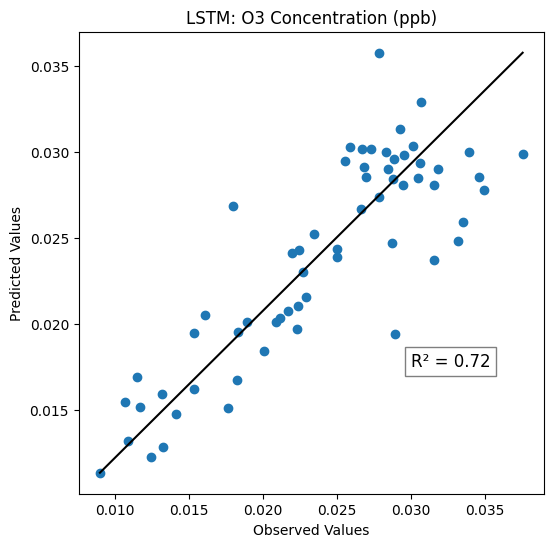

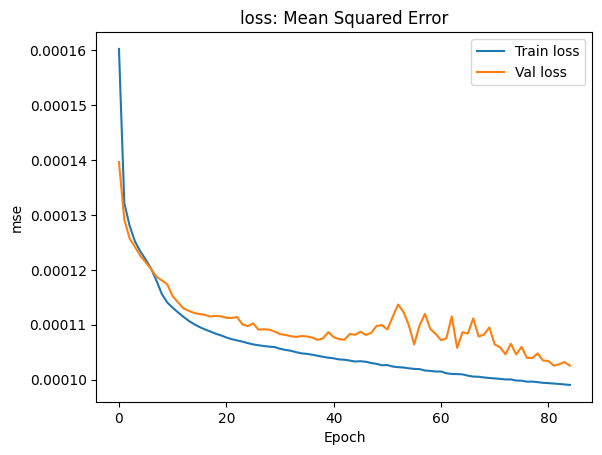

In [21]:
# Organize data into monthly averages and plot
y_test_pre_o33 = y_test_pre_o33.flatten()
y_test_pre_o33 = pd.Series(y_test_pre_o33)
y_test_pre_o33  = y_test_pre_o33.reset_index(drop=True)
time_test_o3 = time_test_o3.reset_index(drop=True)
o3_df  = pd.concat([y_test_pre_o33, time_test_o3], axis=1)
o3_df.columns = ['O3', 'Date']
o3_df['Date'] = pd.to_datetime(o3_df['Date'])

# Extract year and month into new columns
o3_df['Year'] = o3_df['Date'].dt.year
o3_df['Month'] = o3_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
o3_average_values = o3_df.groupby(['Year', 'Month'])['O3'].mean()
o3_average_values_df1 = o3_average_values.reset_index()

#Repeat all above for observed data
y_test_o3 = pd.Series(y_test_o3)
y_test_o3 = y_test_o3.reset_index(drop=True)
time_test_o3 = time_test_o3.reset_index(drop=True)
o3_test_df = pd.concat([y_test_o3, time_test_o3], axis=1)
o3_test_df.columns = ['O3', 'Date']
o3_test_df['Date'] = pd.to_datetime(o3_test_df['Date'])

# Extract year and month into new columns
o3_test_df['Year'] = o3_test_df['Date'].dt.year
o3_test_df['Month'] = o3_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
o3_average_values1 = o3_test_df.groupby(['Year', 'Month'])['O3'].mean()
o3_average_values_df2 = o3_average_values1.reset_index()

#Change the series values to dataframes.
o3_average_values_df1['Date'] = pd.to_datetime(o3_average_values_df1['Year'].astype(str) + '-' + o3_average_values_df1['Month'].astype(str))
o3_average_values_df2['Date'] = pd.to_datetime(o3_average_values_df2['Year'].astype(str) + '-' + o3_average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(o3_average_values_df1['Date'], o3_average_values_df1['O3'], marker='o', label="Predicted Values")  # Create a line plot
plt.plot(o3_average_values_df2['Date'], o3_average_values_df2['O3'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average O3 From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average O3 (ppb)')
plt.legend()
plt.show()

#evaluate the predictions
mse_o3 = mean_squared_error(y_test_o3, y_test_pre_o33)
print("Mean Squared Error:", mse_o3)

mae_o3 = mean_absolute_error(y_test_o3, y_test_pre_o33)
print(f"Mean Absolute Error: {mae_o3}")

rmse_o3 = mean_squared_error(y_test_o3, y_test_pre_o33, squared=False)
print(f"Root Mean Squared Error: {rmse_o3}")

#Prediction Error Histogram
prediction_error(y_test_pre_o33, y_test_so2, 'LSTM','O3')

#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(o3_average_values_df2['O3'], o3_average_values_df1['O3'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(o3_average_values_df2['O3'], o3_average_values_df1['O3'])
plt.plot([o3_average_values_df2['O3'].min(), o3_average_values_df2['O3'].max()], [o3_average_values_df1['O3'].min(), o3_average_values_df1['O3'].max()], 'k-')  
plt.title(f'LSTM: O3 Concentration (ppb)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(0.030, 0.0175 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()


plt.plot()
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('loss: Mean Squared Error')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss','Val loss'])
plt.savefig("LSTMO3.png")


## Meteorological Normalization

In [22]:
df_orig = pd.read_excel("Data/metdata_2018-2023_ELABHWC.xlsx")
sum_of_predictions_co, sum_of_predictions_no2 = np.zeros([43789]), np.zeros([43789])
sum_of_predictions_so2, sum_of_predictions_o3 = np.zeros([43789]), np.zeros([43789])
number_of_iterations = 25

for i in range(number_of_iterations):
    df_rand = pd.read_excel(f"Data/random_weather_datasets/output_{i+1}.xlsx")
    
    df_rand['date_gmt'] = df_orig['date_gmt']
    df_rand['time_gmt'] = df_orig['time_gmt']
    
    df_rand.loc[:, 'wind speed'].fillna(df_new['wind speed'].mean(), inplace=True)
    df_rand.loc[:, 'wind direction'].fillna(df_new['wind direction'].mean(), inplace=True)
    df_rand.loc[:, 'temp'].fillna(df_new['temp'].mean(), inplace=True)
    df_rand.loc[:, 'rh'].fillna(df_new['rh'].mean(), inplace=True)
    df_rand.loc[:, 'pressure'].fillna(df_new['pressure'].mean(), inplace=True)

    X = df_rand[['wind speed', 'wind direction', 'temp', 'rh', 'pressure','date_gmt']]
    
    X = X[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
    #time_co = X_co['date_gmt']
    
    mean, std = X.mean(), X.std()
    
    X = (X - mean)/std
    
    X = X.to_numpy()
    
    X  = np.array([X[i:i+slider] for i in range(0, X.shape[0]-slider+1)])
    
    Y_co = lstm_model1.predict(X).flatten()
    sum_of_predictions_co += Y_co

    Y_no2 = lstm_model2.predict(X).flatten()
    sum_of_predictions_no2 += Y_no2
    
    Y_so2 = lstm_model3.predict(X).flatten()
    sum_of_predictions_so2 += Y_so2
    
    Y_o3 = lstm_model4.predict(X).flatten()
    sum_of_predictions_o3 += Y_o3


average_predictions_co = sum_of_predictions_co / number_of_iterations
average_predictions_no2 = sum_of_predictions_no2 / number_of_iterations
average_predictions_so2 = sum_of_predictions_so2 / number_of_iterations
average_predictions_o3 = sum_of_predictions_o3 / number_of_iterations

timeforplot = df_orig['date_gmt']

1369/1369 [==============================] - 5s 4ms/step


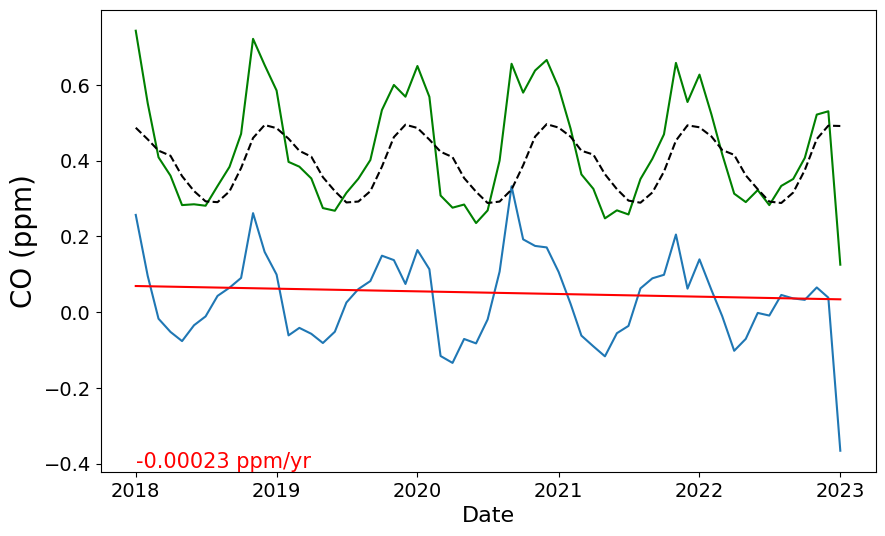

In [27]:
# CO PLOT OF WEATHER NORMALIZATION

weather_norm_co = pd.Series(co_original - average_predictions_co)
y_co = pd.Series(co_original)
weather_prediction_co = pd.Series(average_predictions_co)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
co_df = pd.concat([weather_norm_co, timeforplot], axis=1)
co_df.columns = ['CO', 'Date']
co_df['Date'] = pd.to_datetime(co_df['Date'])

#Group by year and month, then calculate the mean of the 'CO' column
co_df['Year'] = co_df['Date'].dt.year
co_df['Month'] = co_df['Date'].dt.month
average_values_1 = co_df.groupby(['Year', 'Month'])['CO'].mean()

average_values_df1 = average_values.reset_index()

co_actual_df = pd.concat([y_co, timeforplot], axis=1)
co_actual_df.columns = ['CO', 'Date']
co_actual_df['Date'] = pd.to_datetime(co_df['Date'])

#Do the same thing for the observed values
co_df['Year'] = co_df['Date'].dt.year
co_df['Month'] = co_df['Date'].dt.month
average_values = co_df.groupby(['Year', 'Month'])['CO'].mean()
co_actual_df['Year'] = co_actual_df['Date'].dt.year
co_actual_df['Month'] = co_actual_df['Date'].dt.month
average_values_2 = co_actual_df.groupby(['Year', 'Month'])['CO'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_co, timeforplot], axis=1)
weather_df.columns = ['CO', 'Date']
weather_df['Date'] = pd.to_datetime(no2_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['CO'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['CO'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['CO'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['CO'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['CO']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Date', fontsize=16)  # Increase x-axis label font size
plt.ylabel('CO (ppm)', fontsize=20)  # Increase y-axis label font size
plt.text(x_position, y_position, f'{formatted_slope} ppm/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()

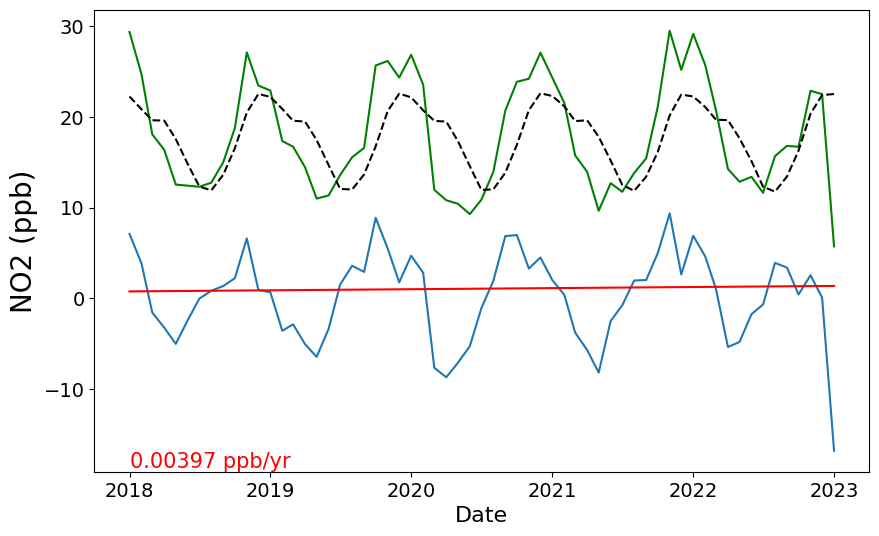

In [24]:
#NO2 PLOT OF WEATHER NORMALIZATION

weather_norm_no2 = pd.Series(no2_original - average_predictions_no2)
y_no2 = pd.Series(no2_original)
weather_prediction_no2 = pd.Series(average_predictions_no2)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
no2_df = pd.concat([weather_norm_no2, timeforplot], axis=1)
no2_df.columns = ['NO2', 'Date']
no2_df['Date'] = pd.to_datetime(no2_df['Date'])

no2_df['Year'] = no2_df['Date'].dt.year
no2_df['Month'] = no2_df['Date'].dt.month
average_values_1 = no2_df.groupby(['Year', 'Month'])['NO2'].mean()

average_values_df1 = average_values.reset_index()

no2_actual_df = pd.concat([y_no2, timeforplot], axis=1)
no2_actual_df.columns = ['NO2', 'Date']
no2_actual_df['Date'] = pd.to_datetime(no2_df['Date'])

#Do the same thing for the observed values
no2_df['Year'] = no2_df['Date'].dt.year
no2_df['Month'] = no2_df['Date'].dt.month
average_values = no2_df.groupby(['Year', 'Month'])['NO2'].mean()
no2_actual_df['Year'] = no2_actual_df['Date'].dt.year
no2_actual_df['Month'] = no2_actual_df['Date'].dt.month
average_values_2 = no2_actual_df.groupby(['Year', 'Month'])['NO2'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_no2, timeforplot], axis=1)
weather_df.columns = ['NO2', 'Date']
weather_df['Date'] = pd.to_datetime(no2_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['NO2'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['NO2'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['NO2'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['NO2'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['NO2']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Date', fontsize=16)  # Increase x-axis label font size
plt.ylabel('NO2 (ppb)', fontsize=20)  # Increase y-axis label font size

plt.text(x_position, y_position, f'{formatted_slope} ppb/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()

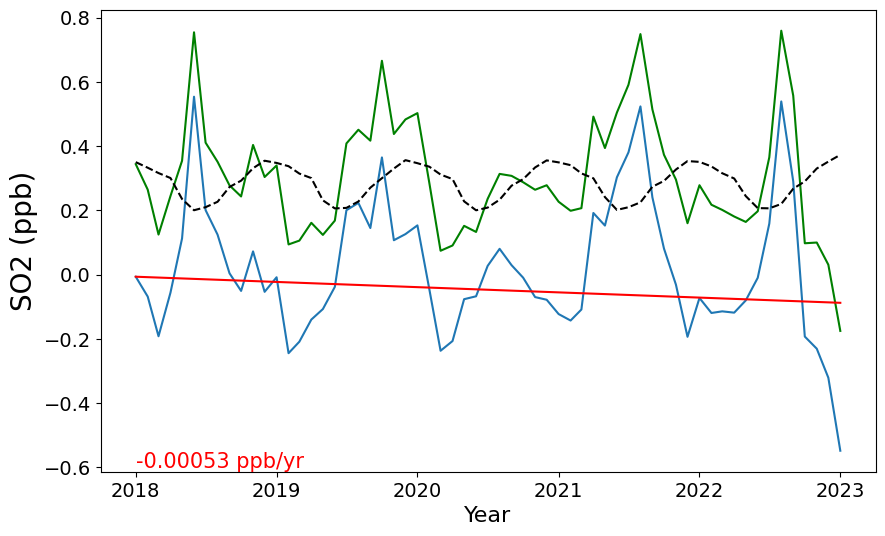

In [25]:
#SO2 PLOT OF WEATHER NORMALIZATION

weather_norm_so2 = pd.Series(so2_original - average_predictions_so2)
y_so2 = pd.Series(so2_original)
weather_prediction_so2 = pd.Series(average_predictions_so2)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
so2_df = pd.concat([weather_norm_so2, timeforplot], axis=1)
so2_df.columns = ['SO2', 'Date']
so2_df['Date'] = pd.to_datetime(so2_df['Date'])

so2_df['Year'] = so2_df['Date'].dt.year
so2_df['Month'] = so2_df['Date'].dt.month
average_values_1 = so2_df.groupby(['Year', 'Month'])['SO2'].mean()

average_values_df1 = average_values.reset_index()

so2_actual_df = pd.concat([y_so2, timeforplot], axis=1)
so2_actual_df.columns = ['SO2', 'Date']
so2_actual_df['Date'] = pd.to_datetime(so2_df['Date'])

#Do the same thing for the observed values
so2_df['Year'] = so2_df['Date'].dt.year
so2_df['Month'] = so2_df['Date'].dt.month
average_values = so2_df.groupby(['Year', 'Month'])['SO2'].mean()
so2_actual_df['Year'] = so2_actual_df['Date'].dt.year
so2_actual_df['Month'] = so2_actual_df['Date'].dt.month
average_values_2 = so2_actual_df.groupby(['Year', 'Month'])['SO2'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_so2, timeforplot], axis=1)
weather_df.columns = ['SO2', 'Date']
weather_df['Date'] = pd.to_datetime(so2_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['SO2'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['SO2'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['SO2'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['SO2'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['SO2']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Year', fontsize=16)  # Increase x-axis label font size
plt.ylabel('SO2 (ppb)', fontsize=20)  # Increase y-axis label font size

plt.text(x_position, y_position, f'{formatted_slope} ppb/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()

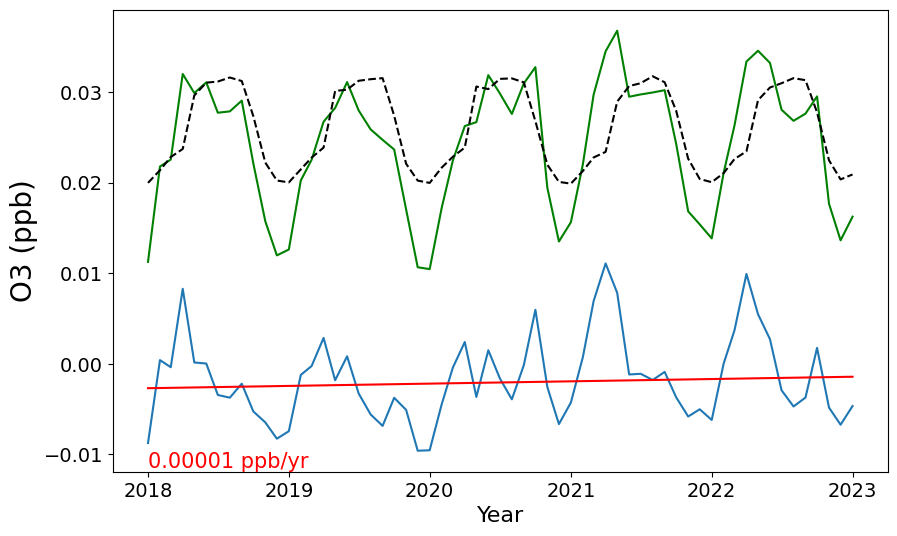

In [26]:
#O3 PLOT OF WEATHER NORMALIZATION

weather_norm_o3 = pd.Series(o3_original - average_predictions_o3)
y_o3 = pd.Series(o3_original)
weather_prediction_o3 = pd.Series(average_predictions_o3)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
o3_df = pd.concat([weather_norm_o3, timeforplot], axis=1)
o3_df.columns = ['O3', 'Date']
o3_df['Date'] = pd.to_datetime(o3_df['Date'])

o3_df['Year'] = o3_df['Date'].dt.year
o3_df['Month'] = o3_df['Date'].dt.month
average_values_1 = o3_df.groupby(['Year', 'Month'])['O3'].mean()

average_values_df1 = average_values.reset_index()

o3_actual_df = pd.concat([y_o3, timeforplot], axis=1)
o3_actual_df.columns = ['O3', 'Date']
o3_actual_df['Date'] = pd.to_datetime(o3_df['Date'])

#Do the same thing for the observed values
o3_df['Year'] = o3_df['Date'].dt.year
o3_df['Month'] = o3_df['Date'].dt.month
average_values = o3_df.groupby(['Year', 'Month'])['O3'].mean()
o3_actual_df['Year'] = o3_actual_df['Date'].dt.year
o3_actual_df['Month'] = o3_actual_df['Date'].dt.month
average_values_2 = o3_actual_df.groupby(['Year', 'Month'])['O3'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_o3, timeforplot], axis=1)
weather_df.columns = ['O3', 'Date']
weather_df['Date'] = pd.to_datetime(o3_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['O3'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['O3'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['O3'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['O3'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['O3']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Year', fontsize=16)  # Increase x-axis label font size
plt.ylabel('O3 (ppb)', fontsize=20)  # Increase y-axis label font size

plt.text(x_position, y_position, f'{formatted_slope} ppb/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()